In [1]:
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ta
import warnings
import pyneurgen
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from Utils import utils

from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial

warnings.filterwarnings('ignore')

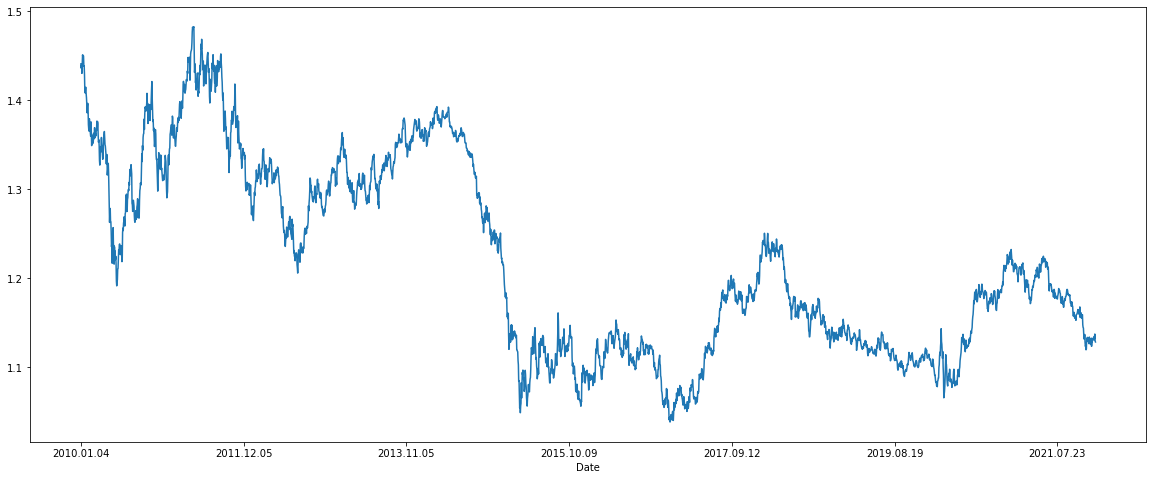

,Open,High,Low,Close,Volume,Median
Date,,,,,,
2010.01.04,1.43259,1.44543,1.42569,1.44111,45505,1.435560
2010.01.05,1.44107,1.44830,1.43467,1.43624,46686,1.441485
2010.01.06,1.43632,1.44338,1.42831,1.43998,45435,1.435845
2010.01.07,1.44001,1.44456,1.42994,1.43041,44298,1.437250
2010.01.08,1.43039,1.44263,1.42634,1.44085,34425,1.434485
...,...,...,...,...,...,...
2021.12.29,1.13079,1.13687,1.12732,1.13477,51231,1.132095
2021.12.30,1.13445,1.13599,1.12988,1.13256,50314,1.132935
2021.12.31,1.13244,1.13861,1.13033,1.13755,39263,1.134470


In [2]:
folder, ticker, period, startdatetime, enddatetime = 'CSVData', 'EURUSD', 'Daily', '201001040000', '202201040000'
multiplier = 100 if 'JPY' in ticker else 10000
ohlcv = pd.read_csv(folder+'/'+ticker+'_'+period+'_'+startdatetime+'_'+enddatetime+'.csv', delimiter='\t')
ohlcv = utils.prep_metatrader_data(ohlcv)
pyplot.figure(figsize=(20,8))
ohlcv['Close'].plot()
pyplot.show()
ohlcv

In [ ]:
label = 'Close'
n = 8
X = utils.timeseries_df(ohlcv, label, n)
y = ohlcv[[label]].iloc[n:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [3]:
X, y = ohlcv['Close'], ohlcv['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
basis_function = Polynomial(degree=5)
model = FROLS(
        order_selection=True,
        n_info_values=10,
        extended_least_squares=False,
        ylag=1,
        xlag=10,
        info_criteria='aic',
        estimator='least_squares',
        basis_function=basis_function
)

In [ ]:
model.fit(X=X_train.to_numpy().reshape(-1, 1), y=y_train.to_numpy().reshape(-1, 1))

In [ ]:
predicted = model.predict(X=X_test.to_numpy().reshape(-1, 1), y=y_test.to_numpy().reshape(-1, 1))

In [ ]:
from sysidentpy.metrics import mean_squared_error, mean_absolute_error
mae = mean_absolute_error(y_test.to_numpy().reshape(-1, 1), predicted)
print(mae)

In [ ]:
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
plot_results(y=y_test, yhat=predicted, n=1000)

In [18]:
import torch
import numpy as np
from torch import nn
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

class NARX(nn.Module):
        def __init__(self):
                super().__init__()
                self.lin = nn.Linear(4, 10)
                self.lin2 = nn.Linear(10, 10)
                self.lin3 = nn.Linear(10, 1)
                self.tanh = nn.Tanh()

        def forward(self, xb):
                z = self.lin(xb)
                z = self.tanh(z)
                z = self.lin2(z)
                z = self.tanh(z)
                z = self.lin3(z)
                return z

basis_function=Polynomial(degree=1)

narx_net = NARXNN(
        net=NARX(),
        ylag=1,
        xlag=8,
        basis_function=basis_function,
        model_type="NARMAX",
        loss_func='mse_loss',
        optimizer='Adam',
        epochs=200,
        verbose=False,
        optim_params={'betas': (0.9, 0.999), 'eps': 1e-05} # optional parameters of the optimizer
)

narx_net.fit(X=torch.from_numpy(X_train.to_numpy().reshape(-1, 1)), y=torch.from_numpy(y_train.to_numpy().reshape(-1, 1)))
#yhat = narx_net.predict(X=X_test.to_numpy().reshape(-1, 1), y=y_test.to_numpy().reshape(-1, 1))
#plot_results(y=y_test.to_numpy().reshape(-1, 1), yhat=yhat, n=200)

RuntimeError: Numpy is not available

In [17]:
#regr = MLPRegressor(hidden_layer_sizes=[500, 200], 
#                    max_iter=1000, n_iter_no_change=500, verbose=False)

#regr.fit(X_train, y_train.to_numpy().ravel())


predicted = regr.predict(X_test)

diff = predicted - y_test[label]
diff_df = pd.DataFrame({'Actual': y_test[label], 
                        'Predicted': predicted,
                        'Difference': diff})

mae = mean_absolute_error(predicted, y_test)
ohlcv_test = ohlcv[ohlcv.index.isin(X_test.index)]
ach = sum(abs(ohlcv_test['High']-ohlcv_test['Low']))/len(diff)
print('Mean absolute error: ' + str(round(mae*multiplier,2)) + ' pips')
print('Average candle range: ' + str(round(ach*multiplier,2)) + ' pips')

NameError: name 'regr' is not defined

In [ ]:
y_pred = pd.DataFrame(index = ohlcv_test.index)
y_pred['y_pred'] = predicted
y_pred['low'], y_pred['high'] = ohlcv_test['Low'], ohlcv_test['High']
y_pred['open'], y_pred['close'] = ohlcv_test['Open'], ohlcv_test['Close'] 
y_pred

In [ ]:
y_pred, hitrate = utils.get_hitrate(y_pred)
pyplot.figure(figsize=(25,15))
y_pred['high'].plot()
y_pred['low'].plot()
y_pred['y_pred'].plot(marker = 'o')
pyplot.show()
print('Hitrate: ' + str(round(hitrate*100,2)) + '%')
print('Number of candles: ' + str(len(y_pred)))

In [ ]:
y_pred, direction = utils.get_direction(y_pred)
y_pred, OR = utils.get_OR(y_pred)
y_pred, pips = utils.get_pips(y_pred, multiplier)
print('Direction: ' + str(round(direction*100,2)) + '%')
print('OR: ' + str(round(OR*100,2)) + '%')
print('Total pips: ' + str(round(pips,2)))

In [ ]:
sum(y_pred[y_pred['pips']>=0]['pips'])

In [ ]:
y_pred.to_excel('y_pred.xlsx')